<a href="https://colab.research.google.com/github/mitsuo/juntendo-hds/blob/main/MONAI_Segmentation_ChestRadiologyImages%E6%94%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに
放射線医療現場でのAIを用いたプロジェクトを進めるにあたり、さまざまな実験を試す必要があります。そこで、この記事では放射線治療現場でのAIを用いた自動輪郭抽出の実験管理をWeight&Biases(wandb)のプラットフォームを使って管理する方法について共有します。

この記事を読むことで得られる知識
- 放射線治療現場でのAIを用いた自動輪郭抽出の現状を理解
- Weight&Biasesを用いた実験管理

# 全体の流れ

![Image Segmentation](https://raw.githubusercontent.com/elith-co-jp/prj-medical-seminars/main/monai-seminar/monai_seminar_flow.png)

<small>GitHub: [GitHub](https://github.com/elith-co-jp/prj-medical-seminars)</small>

# データ準備
- このパートでは学習するデータを作成します
- MONAIで利用する場合は、少し工夫する必要があります
- 領域予測したい領域を1、背景を0にしてDICOM形式(.dcm)から機械学習でよく利用されるNumpy(.npy)で保存します

![Image Segmentation](https://raw.githubusercontent.com/elith-co-jp/prj-medical-seminars/main/monai-seminar/fig5-2.png)

<small>GitHub: [GitHub](https://github.com/elith-co-jp/prj-medical-seminars)</small>

## 環境のセットアップ

In [1]:
!pip install monai[pydicom]
!pip install rt_utils -q
!pip install nibabel -q
!pip install pydicom -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 65.3 MB/s eta 0:00:00


## データセットのダウンロード

AAPM2017で実施された胸部放射線のセグメンテーションチャレンジ「Auto-Segmentation for Thoracic Radiation Treatment Planning: A Grand Challenge」のデータを利用します。

In [2]:
!gdown --id 1TXH4PnMcU-23irtZZShZ80ClpJPedZL_ -O ./LCTSC_DICOM.zip
!unzip LCTSC_DICOM.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1TXH4PnMcU-23irtZZShZ80ClpJPedZL_
From (redirected): https://drive.google.com/uc?id=1TXH4PnMcU-23irtZZShZ80ClpJPedZL_&confirm=t&uuid=235a2822-8b50-4bb3-be58-1f8807b2f9fc
To: /content/LCTSC_DICOM.zip
100% 480M/480M [00:08<00:00, 54.4MB/s]
Archive:  LCTSC_DICOM.zip
   creating: LCTSC_DICOM/LCTSC-Test-S1-101/03-03-2004-NA-NA-08186/.ipynb_checkpoints/
  inflating: LCTSC_DICOM/LCTSC-Train-S1-011/.DS_Store  
  inflating: LCTSC_DICOM/LCTSC-Train-S1-012/.DS_Store  
  inflating: LCTSC_DICOM/LCTSC-Train-S1-012/01-18-2004-NA-RTRCCTTHORAX8FHigh Adult-72341/.DS_Store  
  inflating: LCTSC_DICOM/LCTSC-Train-S1-011/12-21-2003-NA-RTRCCTTHORAX8FHigh Adult-85618/.DS_Store  
  inflating: LCTSC_DICOM/LCTSC-Train-S1-007/12-13-20

## セグメンテーション画像の確認
---

DICOM画像のシリーズとRT（放射線療法）構造データから特定の領域（ここでは"肺（Lung_R）"）のマスクを生成し、そのマスクの一部を表示します。

RT構造データは、患者の体内の特定の領域（例えば、腫瘍や器官）を識別するための情報を含んでおり、これを利用して3Dマスクを生成し、そのマスクを用いて画像上での領域の位置を確認することができます。


In [3]:
patient_dir_path = "./LCTSC_DICOM/LCTSC-Train-S1-007/12-13-2003-NA-RTRCCTTHORAX8FHigh Adult-15875/0.000000-CTP1B3RespCT  3.0  B30f  50 Ex-86710"
segment_path = "./LCTSC_DICOM/LCTSC-Train-S1-007/12-13-2003-NA-RTRCCTTHORAX8FHigh Adult-15875/1.000000-.simplified-17709/1-1.dcm"

['SpinalCord', 'Lung_R', 'Lung_L', 'Heart', 'Esophagus']


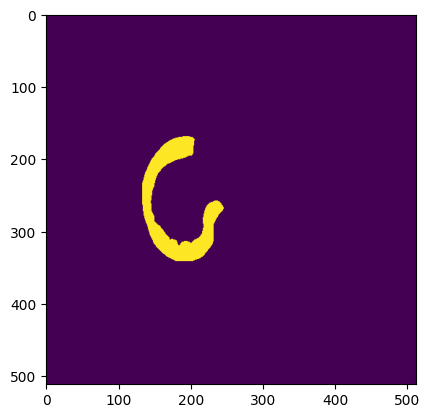

In [4]:
from rt_utils import RTStructBuilder  # RT Structure（放射線治療計画）ファイルの操作に必要なライブラリ
import matplotlib.pyplot as plt

# 既存のRT構造データを読み込みます
rtstruct = RTStructBuilder.create_from(
  dicom_series_path=patient_dir_path,
  rt_struct_path=segment_path
)

print(rtstruct.get_roi_names())


# RT構造データから3Dマスクを取得します
mask_3d = rtstruct.get_roi_mask_by_name("Lung_R")

#　"Lung_R"という領域の一部を可視化
first_mask_slice = mask_3d[:, :, 50]
plt.imshow(first_mask_slice)
plt.show()

### データセット作成

内臓のセグメンテーションしたい領域を1、背景を0にしてDICOM形式(.dcm)から機械学習でよく利用されるNumpy(.npy)で保存します。  


***マスクデータの作成***

各患者で学習用に右肺(Lung_R)の0と1の値で構成されたマスクデータを作成します。

3ステップでマスクデータを保存します。

1. 再帰的に各患者ごとCTが入った0始まりのディレクトリと、セグメンテーションアノテーションされた1始まりのディレクトリ内のDICOMを取得

2. 取得したパスをAIモデルで学習するためにCSVに保存

3. 最後に各患者ごとのマスクデータをDICOM形式からnumpy形式に変換し保存


In [5]:
# Step1
import os
from glob import glob

# DICOM画像が保存されているディレクトリのルートパスを設定
patient_dcm_root_dir = "."

# 患者CTデータのディレクトリを再帰的に取得
search_dcm_dir = f"{patient_dcm_root_dir}/*/*/*/0*"
patient_dcm_dirs = list(glob(search_dcm_dir))
patient_dcm_dirs = sorted(patient_dcm_dirs)
patient_dcm_dirs = [os.path.relpath(path, patient_dcm_root_dir) for path in patient_dcm_dirs]

# 患者セグメンテーションアノテーションされたDICOMを再帰的に取得
search_mask_dir = f"{patient_dcm_root_dir}/*/*/*/1*"
patient_mask_dirs = list(glob(search_mask_dir))
patient_mask_dirs = sorted(patient_mask_dirs)
patient_mask_dcm_paths = [p + "/1-1.dcm" for p in patient_mask_dirs] # 各マスク画像のファイルパス（1-1.dcm）を取得
patient_mask_dcm_paths = [os.path.relpath(path, patient_dcm_root_dir) for path in patient_mask_dcm_paths]

print(len(patient_dcm_dirs), len(patient_mask_dcm_paths))

16 16


In [6]:
# Step2
import pandas as pd

df = pd.DataFrame()

# 患者のDICOMディレクトリとマスクDICOMのパスを格納します。
df["patient_dcm_dir"] = patient_dcm_dirs
df["patient_mask_dcm_path"] = patient_mask_dcm_paths

# numpy形式で保存するマスクのパス
df["patient_mask_save_np_path"] = df['patient_dcm_dir'].apply(lambda x: x.split('/')[1]) + ".npy"

df.head()

,patient_dcm_dir,patient_mask_dcm_path,patient_mask_save_np_path
0,LCTSC_DICOM/LCTSC-Test-S1-101/03-03-2004-NA-NA...,LCTSC_DICOM/LCTSC-Test-S1-101/03-03-2004-NA-NA...,LCTSC-Test-S1-101.npy
1,LCTSC_DICOM/LCTSC-Test-S1-102/11-04-2003-NA-RT...,LCTSC_DICOM/LCTSC-Test-S1-102/11-04-2003-NA-RT...,LCTSC-Test-S1-102.npy
2,LCTSC_DICOM/LCTSC-Test-S1-103/11-09-2003-NA-RT...,LCTSC_DICOM/LCTSC-Test-S1-103/11-09-2003-NA-RT...,LCTSC-Test-S1-103.npy
3,LCTSC_DICOM/LCTSC-Test-S1-104/11-16-2003-NA-Sp...,LCTSC_DICOM/LCTSC-Test-S1-104/11-16-2003-NA-Sp...,LCTSC-Test-S1-104.npy
4,LCTSC_DICOM/LCTSC-Train-S1-001/11-16-2003-NA-R...,LCTSC_DICOM/LCTSC-Train-S1-001/11-16-2003-NA-R...,LCTSC-Train-S1-001.npy


In [7]:
# 最初の患者の各パスを表示します。
print(df.patient_dcm_dir.values[0])
print(df.patient_mask_dcm_path.values[0])
print(df.patient_mask_save_np_path.values[0])

LCTSC_DICOM/LCTSC-Test-S1-101/03-03-2004-NA-NA-08186/0.000000-CT
LCTSC_DICOM/LCTSC-Test-S1-101/03-03-2004-NA-NA-08186/1.000000-NA-56597/1-1.dcm
LCTSC-Test-S1-101.npy


In [8]:
# csvファイルの保存
df.to_csv("train.csv", index=False)

In [9]:
# Step3
import numpy as np

# データフレームの各行について、それぞれの患者のDICOMディレクトリとマスクDICOMのパス、保存するマスクのnumpy形式のパスを取得します。
for index, row in df.iterrows():
    patient_dcm_dir = os.path.join(patient_dcm_root_dir,row['patient_dcm_dir'])
    patient_mask_dcm_path = os.path.join(patient_dcm_root_dir,row['patient_mask_dcm_path'])
    patient_mask_save_np_path = row['patient_mask_save_np_path']

    # DICOMファイルとRT構造ファイルからRT構造を作成します。
    rtstruct = RTStructBuilder.create_from(
      dicom_series_path=patient_dcm_dir,
      rt_struct_path=patient_mask_dcm_path
    )

    # "Lung_R"という名前の右肺の領域に対応する3Dマスクを取得します。
    mask_3d = rtstruct.get_roi_mask_by_name("Lung_R")
    print(mask_3d.shape)

    # 3Dマスクをnumpy形式で保存
    np.save(patient_mask_save_np_path, mask_3d)

(512, 512, 130)
(512, 512, 148)
(512, 512, 152)
(512, 512, 131)
(512, 512, 140)
(512, 512, 161)
(512, 512, 154)
(512, 512, 158)
(512, 512, 136)
(512, 512, 140)
(512, 512, 148)
(512, 512, 134)
(512, 512, 150)
(512, 512, 122)
(512, 512, 162)
(512, 512, 131)


In [10]:
# 保存した3Dマスクを読み込み、その形状を表示します
mask_3d_sample = np.load("./LCTSC-Test-S1-101.npy")
mask_3d_sample.shape

(512, 512, 130)

# 学習

はじめにMONAIで必要なパッケージをインストールします。

In [11]:
#!pip install monai[pydicom] -q
#!pip install rt_utils -q
#!pip install nibabel -q
#!pip install pydicom -q
!pip install wandb -q

実験に再現性を持たせるために乱数固定します。

In [12]:
import torch
import numpy as np
import random

def seed_everything(seed_value):
    random.seed(seed_value)  # Pythonの乱数を固定
    np.random.seed(seed_value)  # Numpyの乱数を固定
    torch.manual_seed(seed_value)  # PyTorchの乱数を固定

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)  # GPUを使う場合、PyTorchの乱数を固定
        torch.cuda.manual_seed_all(seed_value)  # 全てのGPUを使う場合、PyTorchの乱数を固定
        torch.backends.cudnn.deterministic = True  # cuDNNの決定論的モードをON
        torch.backends.cudnn.benchmark = False  # ベンチマークモードをOFF

seed_everything(42)

学習に必要なライブラリをインポートします

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 医療画像処理とAI関連ライブラリ
import pydicom  # DICOM形式の医療画像を読み書きするためのライブラリ
from rt_utils import RTStructBuilder  # RT Structure（放射線治療計画）ファイルの操作に必要なライブラリ

import torch
from monai.transforms import ResizeD, Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.data import DataLoader, Dataset
from monai.utils import set_determinism
from monai.inferers import sliding_window_inference
import wandb

## データの分割
学習データ、評価データ、テストデータに分割します。

それぞれ、12名(75.0%)、2名(12.5%)、2名(12.5%)で分割しています。

In [15]:
test_df = df[:2]
val_df = df[2:4]
train_df = df[4:]

train_df.shape, val_df.shape, test_df.shape

((12, 3), (2, 3), (2, 3))

## 前処理
MONAIでデータを扱えるようにします。

In [16]:
# 訓練、検証、テストのデータリストを初期化
train_data = []
val_data = []
test_data = []

patient_dcm_root_dir = './'

# 訓練データ
for index, row in train_df.iterrows():
    train_dict = {}

    # 画像とラベル（マスク）のフルパスをディクショナリに保存
    train_dict["image"] = os.path.join(patient_dcm_root_dir,row['patient_dcm_dir'])
    train_dict["label"] = os.path.join(patient_dcm_root_dir,row['patient_mask_save_np_path'])

    # ディクショナリを訓練データリストに追加
    train_data.append(train_dict)

# 検証データ
for index, row in val_df.iterrows():
    val_dict = {}

    # 画像とラベル（マスク）のフルパスをディクショナリに保存
    val_dict["image"] = os.path.join(patient_dcm_root_dir,row['patient_dcm_dir'])
    val_dict["label"] = os.path.join(patient_dcm_root_dir,row['patient_mask_save_np_path'])

    # ディクショナリを検証データリストに追加
    val_data.append(val_dict)

# テストデータ
for index, row in test_df.iterrows():
    test_dict = {}

    # 画像とラベル（マスク）のフルパスをディクショナリに保存
    test_dict["image"] = os.path.join(patient_dcm_root_dir,row['patient_dcm_dir'])
    test_dict["label"] = os.path.join(patient_dcm_root_dir,row['patient_mask_save_np_path'])

    # ディクショナリをテストデータリストに追加
    test_data.append(test_dict)

学習中に行う前処理を設定します

In [18]:
# 訓練データのトランスフォームを定義
# 画像とラベルのロード、次元の追加、リサイズ、強度のスケーリング、そしてテンソルへの変換を行います
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeD(keys=["image", "label"], spatial_size=(96, 96, 96)),
    ScaleIntensityd(keys="image"),
    ToTensord(keys=["image", "label"])
])

# 検証データのトランスフォームを定義
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    ResizeD(keys=["image", "label"], spatial_size=(96, 96, 96)),
    ScaleIntensityd(keys="image"),
    ToTensord(keys=["image", "label"])
])

## データローダーの作成

In [19]:
# 訓練データセットとデータローダーを作成
train_ds = Dataset(data=train_data, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)

# 検証データセットとデータローダーを作成
val_ds = Dataset(data=val_data, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=2)

# テストデータセットとデータローダーを作成
test_ds = Dataset(data=test_data, transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

## モデルの設定
学習用のモデルと学習に利用する変数を設定します。  
モデルはU-Netを3次元に拡張した3D U-Netを利用します。


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    "num_workers": 4,
    # train settings
    "train_batch_size": 2,
    "val_batch_size": 2,
    "learning_rate": 1e-3,
    "max_epochs": 100,
    "val_interval": 1, # 検証の間隔
    "device": device,
    "model_type": "unet",
    "model_params": dict(spatial_dims=3,
                  in_channels=1,
                  out_channels=1,
                  channels=(16, 32, 64, 128, 256),
                  strides=(2, 2, 2, 2),
                  num_res_units=2,
                  norm=Norm.BATCH,
    ),
    "loss_type": "DiceLoss",
    "optimizer_type": "Adam",
    "metric": 'DiceMetric'
}

# モデルを定義
model = UNet(**config['model_params']).to(device)

# 損失関数DiceLoss
loss_function = DiceLoss(sigmoid=True)

# オプティマイザ
optimizer = torch.optim.Adam(model.parameters(), config['learning_rate'])

# 最大エポック数
max_epochs = config['max_epochs']

# 検証の間隔
val_interval = config['val_interval']

# 最高の評価指標の値とその時のエポック数を保存するための変数
best_metric = -1
best_metric_epoch = -1

# エポックごとの損失値と評価指標の値を保存するためのリスト
epoch_loss_values = list()
metric_values = list()

# 評価関数
dice_metric = DiceMetric(include_background=True, reduction='mean')

学習状態を記録するwandbの設定を行います。  
実行時にAPI keyを入力するように言われるので、入力しましょう。  
wandb起動時に学習時の設定を保存しています。  
これにより、実験時のパラメータがわかり、再現実験をしやすくなります。

In [22]:
wandb.init(project="MONAI_Segmentation_ChestRadiologyImages", config=config)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mitsuo (team-mitsuo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 学習コードの実行
モデルの設定が終わりましたので、学習していきましょう。

今回はエポックごとに評価データを用いて評価値を算出し、学習データに過学習しないようにしています。  
また、各エポックごとにモデルの評価値をwandbで記録します。

In [23]:
# 最大エポック数だけループを回す
for epoch in range(max_epochs):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # 訓練データローダーからバッチを取得
    for batch_data in train_loader:
        step += 1  # ステップ数をインクリメント
        inputs, labels = batch_data['image'].to(device), batch_data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    wandb.log({'train/loss': epoch_loss}, step=epoch+1)

    # 検証間隔ごとに検証を行う
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.
            metric_count = 0
            for val_data in val_loader:
                val_inputs, val_labels = val_data['image'].to(device), val_data['label'].to(device)
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                # 検証結果を取得
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                # Diceメトリックを計算
                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            wandb.log({'val/metric': metric}, step=epoch+1)
            # メトリックが改善していればモデルを保存
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                  f" best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


# ベストスコアをwandbに記録
wandb.log({"best_metric": best_metric, "best_metric_epoch": best_metric_epoch})

----------
epoch 1/100
1/6, train_loss: 0.9558
2/6, train_loss: 0.9691
3/6, train_loss: 0.9596
4/6, train_loss: 0.9362
5/6, train_loss: 0.9561
6/6, train_loss: 0.9388
epoch 1 average loss: 0.9526


/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  out

saved new best metric model
current epoch: 1 current mean dice: 0.0000 best mean dice: 0.0000 at epoch: 1
----------
epoch 2/100
1/6, train_loss: 0.9460
2/6, train_loss: 0.9518
3/6, train_loss: 0.9378
4/6, train_loss: 0.9417
5/6, train_loss: 0.9335
6/6, train_loss: 0.9353
epoch 2 average loss: 0.9410
current epoch: 2 current mean dice: 0.0000 best mean dice: 0.0000 at epoch: 1
----------
epoch 3/100
1/6, train_loss: 0.9290
2/6, train_loss: 0.9362
3/6, train_loss: 0.9409
4/6, train_loss: 0.9196
5/6, train_loss: 0.9336
6/6, train_loss: 0.9396
epoch 3 average loss: 0.9331
current epoch: 3 current mean dice: 0.0000 best mean dice: 0.0000 at epoch: 1
----------
epoch 4/100
1/6, train_loss: 0.9385
2/6, train_loss: 0.9166
3/6, train_loss: 0.9369
4/6, train_loss: 0.9289
5/6, train_loss: 0.9269
6/6, train_loss: 0.9105
epoch 4 average loss: 0.9264
current epoch: 4 current mean dice: 0.0000 best mean dice: 0.0000 at epoch: 1
----------
epoch 5/100
1/6, train_loss: 0.9141
2/6, train_loss: 0.9096
3

In [24]:
torch.save(model.state_dict(), 'last_model.pth')
print('saved last metric model')

saved last metric model


# 推論
テストデータに対して推論を行い、評価を確認します。

In [26]:
# 学習済みの重みをロード
#model_path = "best_metric_model.pth"
model_path = "last_model.pth"
model.load_state_dict(torch.load(model_path))
model.eval()  # モデルを評価モードに設定

columns = ['ground_truth', 'prediction', 'metric']
test_table = wandb.Table(columns=columns)

# テストデータに対して推論を行う
with torch.no_grad():  # 勾配の計算を無効化
    for i, test_data in enumerate(test_loader):
        test_inputs, test_labels = test_data['image'].to(device), test_data['label'].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        # モデルを介して入力を伝播し、推論結果を取得
        test_outputs = sliding_window_inference(test_inputs, roi_size, sw_batch_size, model)

        # sigmoid関数を適用し0~1の値に変換
        test_outputs_binary = torch.sigmoid(test_outputs)

        # 0.5を閾値として、それ以下の値を0、それ以上の値を1に変換
        test_outputs_binary = (test_outputs_binary >= 0.5).float()

        test_outputs_np = test_outputs_binary.cpu().numpy()
        test_labels_np = test_labels.cpu().numpy()

        # 可視化のために次元を変換 (1, 96, 96, 96) => (96, 96, 96)
        test_outputs_np = np.reshape(test_outputs_np, (96, 96, 96))
        test_labels_np = np.reshape(test_labels_np, (96, 96, 96))
        # NumPy配列をファイルに保存
        np.save(f'test_output_{i}.npy', test_outputs_np)
        # Diceメトリックを計算
        metric = dice_metric(y_pred=test_outputs, y=test_labels)
        metric = metric.cpu().item()

        test_table.add_data([wandb.Image(img) for img in test_labels_np], [wandb.Image(img) for img in test_outputs_np], metric)


    test_metric = dice_metric.aggregate().item()  # Diceメトリックの平均を計算
    print(f"Dice metric on test data: {test_metric:.4f}")
wandb.log({'test_metric': test_metric})
wandb.log({"test_predictions" : test_table})

# wandb.finish()

Dice metric on test data: 0.0000


## 予測結果の確認
予測した結果を確認します。CTは3Dデータなので、3Dでスライドしながら結果を確認していきます。

コードは、3D配列pred_maskをスライスして各スライスをアニメーションとして表示します。スライスは配列の3番目の次元（z軸）に沿って取られ、各フレームで表示されます。アニメーションはJupyter Notebook内でHTMLとして表示されます。

In [27]:
import numpy as np  # NumPyをインポート
import matplotlib.pyplot as plt  # Matplotlibのpyplotをインポート
import matplotlib.animation as animation  # Matplotlibのanimationをインポート
from IPython.display import HTML  # Jupyter notebook上でHTMLを表示するための関数をインポート

pred_mask = np.load("test_output_0.npy")  # 3D配列（予測マスク）をNumPyのnpyファイルから読み込む

fig, ax = plt.subplots()  # 新しい図と座標系を作成

# この関数はアニメーションの各フレームで呼び出されます
def update(i):
    ax.clear()  # 現在の座標系をクリア
    ax.imshow(pred_mask[:, :, i], cmap='gray')  # 3D配列のスライスを表示

# アニメーションを作成
ani = animation.FuncAnimation(fig, update, interval=100, frames=range(pred_mask.shape[2]))

plt.close()  # 二重に図が表示されるのを防ぐために図を閉じる

# アニメーションをHTMLに変換
HTML(ani.to_jshtml())

In [28]:
# テストデータに対して推論を行う
with torch.no_grad():  # 勾配の計算を無効化
    for i, test_data in enumerate(test_loader):  # テストデータローダーからバッチを取得
        _ , test_labels = test_data['image'].to(device), test_data['label'].to(device)  # データとラベルをGPUに移動
        roi_size = (160, 160, 160)
        sw_batch_size = 4

        # テスト出力をCPUに戻し、NumPy配列に変換
        test_outputs_np = test_labels.cpu().numpy()

        # 可視化のために次元を変換 (1, 96, 96, 96) => (96, 96, 96)
        test_outputs_np = np.reshape(test_outputs_np, (96, 96, 96))
        # NumPy配列をファイルに保存
        np.save(f'test_gt_{i}.npy', test_outputs_np)

In [29]:
gt_mask = np.load("test_gt_0.npy")  # 3D配列（予測マスク）をNumPyのnpyファイルから読み込む

fig, ax = plt.subplots()  # 新しい図と座標系を作成

# この関数はアニメーションの各フレームで呼び出されます
def update(i):
    ax.clear()  # 現在の座標系をクリア
    ax.imshow(gt_mask[:, :, i], cmap='gray')  # 3D配列のスライスを表示

# アニメーションを作成
ani = animation.FuncAnimation(fig, update, interval=100, frames=range(gt_mask.shape[2]))

plt.close()  # 二重に図が表示されるのを防ぐために図を閉じる

# アニメーションをHTMLに変換
HTML(ani.to_jshtml())